<a href="https://colab.research.google.com/github/MAristyaP/Mesin_Learning2023/blob/main/LabWork10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I'm somewhat of a fan of Lynche's work, so I was excited when I found this DVD. Unfortunately, I was very let down. It's a series of short cartoons which attempt to show a disturbing and disgusting sort of humor. The animation is very crude, no doubt done using Macromedia. Each cartoon has a big fat guy beating up his family and generally acting like a jerk to everyone he knows. <br /><br />For people who are not familiar with this vein of animation, they will probably be somewhat impressed by it. However, if you've spent much time on Newgrounds.com, like me, then these cartoons will be no different than any of the other stuff you've seen before. Many of the popular amateur artists on Newgrounds are doing much better work than what was shown on this DVD. If Lynch submitted this work to the website, then he would blend in perfectly with some of the better of Newgrounds artists. But, since I saw this on DVD, instead of on Newgrounds, I give it a 4/10, instead of a 7/10, as I w

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[142, 610,   5, ...,   0,   0,   0],
       [  1,  36,   1, ...,   0,   0,   0],
       [ 83,  10, 118, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I'm somewhat of a fan of Lynche's work, so I was excited when I found this DVD. Unfortunately, I was very let down. It's a series of short cartoons which attempt to show a disturbing and disgusting sort of humor. The animation is very crude, no doubt done using Macromedia. Each cartoon has a big fat guy beating up his family and generally acting like a jerk to everyone he knows. <br /><br />For people who are not familiar with this vein of animation, they will probably be somewhat impressed by it. However, if you've spent much time on Newgrounds.com, like me, then these cartoons will be no different than any of the other stuff you've seen before. Many of the popular amateur artists on Newgrounds are doing much better work than what was shown on this DVD. If Lynch submitted this work to the website, then he would blend in perfectly with some of the better of Newgrounds artists. But, since I saw this on DVD, instead of on Newgrounds, I give it a 4/10, instead of a 7/10, as I

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00982787]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[-0.00982787]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 55s 114ms/step - loss: 0.6608 - accuracy: 0.5542 - val_loss: 0.5894 - val_accuracy: 0.6250
Epoch 2/10
391/391 [==============================] - 28s 71ms/step - loss: 0.4426 - accuracy: 0.7770 - val_loss: 0.3874 - val_accuracy: 0.8266
Epoch 3/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3462 - accuracy: 0.8467 - val_loss: 0.3641 - val_accuracy: 0.8411
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3230 - accuracy: 0.8572 - val_loss: 0.3388 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3139 - accuracy: 0.8649 - val_loss: 0.3306 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3078 - accuracy: 0.8678 - val_loss: 0.3284 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3051 - accuracy: 0.8686 - val_loss: 0.3235 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3142 - accuracy: 0.8613
Test Loss: 0.31423795223236084
Test Accuracy: 0.8612800240516663


(0.0, 0.6788405731320382)

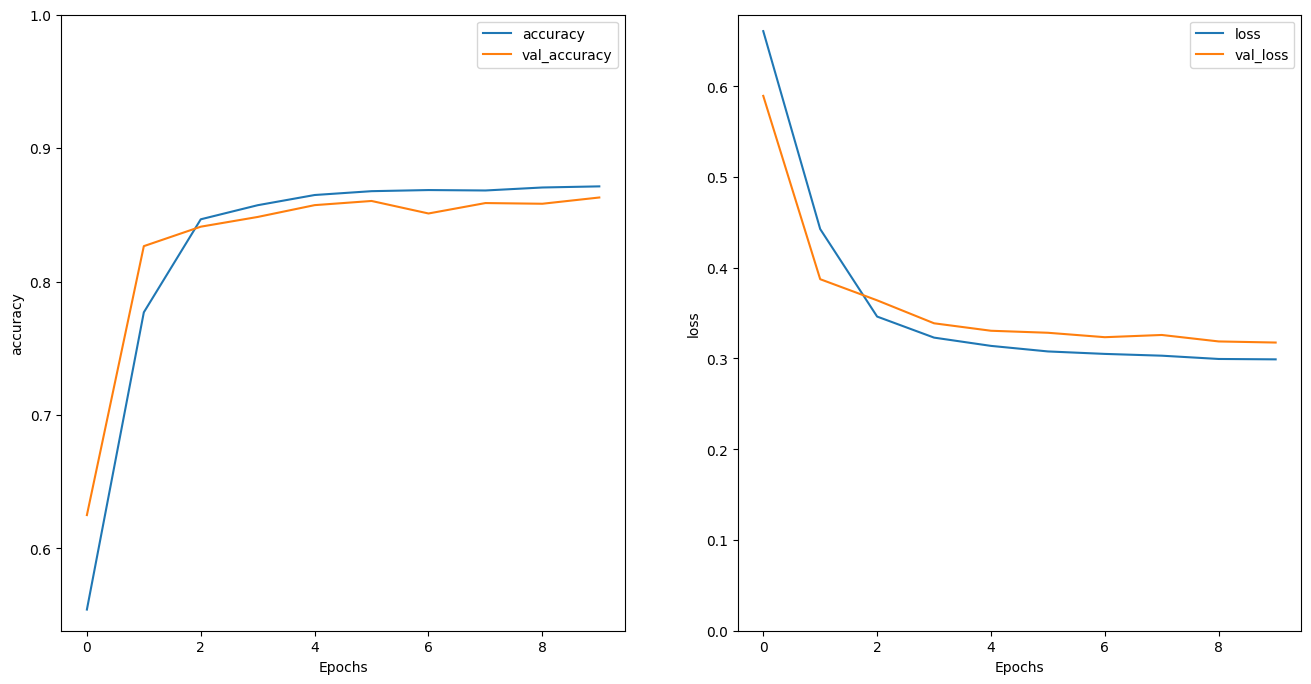

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 159ms/step - loss: 0.6256 - accuracy: 0.5748 - val_loss: 0.4675 - val_accuracy: 0.7979
Epoch 2/10
391/391 [==============================] - 48s 123ms/step - loss: 0.4033 - accuracy: 0.8227 - val_loss: 0.3626 - val_accuracy: 0.8448
Epoch 3/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3515 - accuracy: 0.8462 - val_loss: 0.3432 - val_accuracy: 0.8391
Epoch 4/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3317 - accuracy: 0.8573 - val_loss: 0.3417 - val_accuracy: 0.8599
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3156 - accuracy: 0.8662 - val_loss: 0.3261 - val_accuracy: 0.8625
Epoch 6/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3119 - accuracy: 0.8651 - val_loss: 0.3195 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3026 - accuracy: 0.8698 - val_loss: 0.3214 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 50ms/step - loss: 0.3365 - accuracy: 0.8512
Test Loss: 0.3365410566329956
Test Accuracy: 0.8511999845504761


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.0275936]]


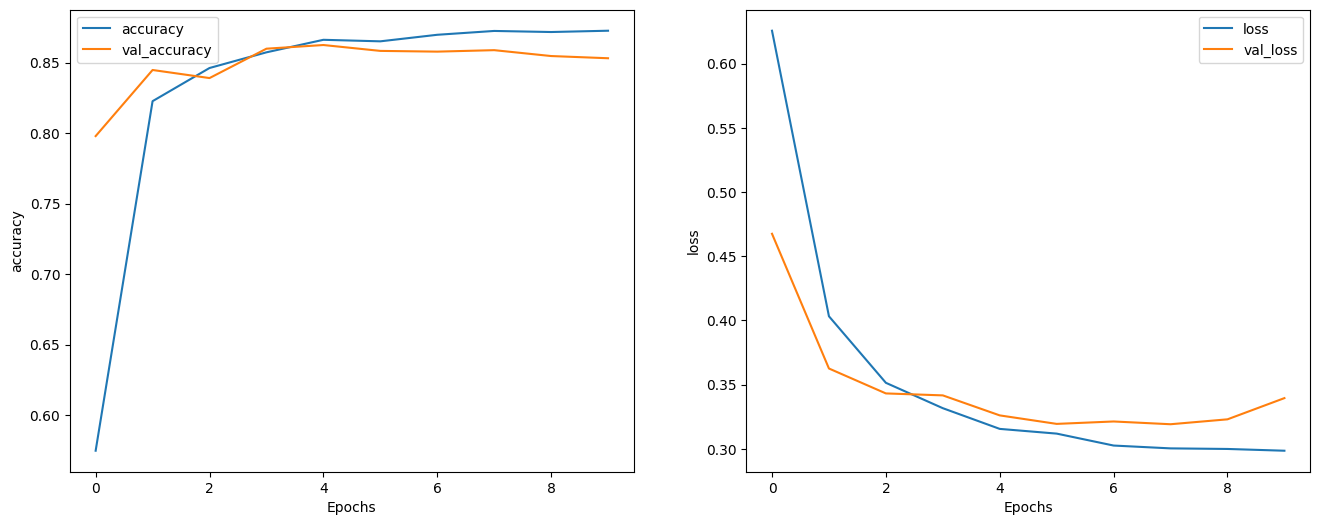

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

LabWork 2

In [25]:
import tensorflow as tf
import numpy as np
import os
import time

In [26]:
path_to_file=tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 1s 1us/step


In [27]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [28]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [29]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [30]:
example_texts=['abcdefg','xyz']
chars=tf.strings.unicode_split(example_texts,input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [31]:
ids_from_chars=tf.keras.layers.StringLookup(vocabulary=list(vocab),mask_token=None)

In [32]:
ids=ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [33]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [34]:
chars=chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [35]:
tf.strings.reduce_join(chars,axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [36]:
all_ids=ids_from_chars(tf.strings.unicode_split(text,'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [37]:
ids_dataset=tf.data.Dataset.from_tensor_slices(all_ids)

In [38]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [39]:
seq_length=100

In [40]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [41]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
    return tf.strings.reduce_join(ids_from_chars(ids), axis=-1).numpy()

In [42]:
for seq in sequences.take(5):
    print(text_from_ids(seq))

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [43]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [44]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [45]:
dataset = sequences.map(split_input_target)

In [46]:
for input_example,target_example in dataset.take(1):
    print("Input :",text_from_ids(input_example))
    print("Target:",text_from_ids(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [47]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [48]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [49]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [50]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [51]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [52]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
sampled_indices=tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices=tf.squeeze(sampled_indices,axis=-1).numpy()

In [54]:
sampled_indices

array([57, 50, 22, 21, 33, 21, 24, 33, 29, 39, 44, 24, 13, 56, 59, 49, 35,
       33,  8, 30, 16, 35, 27, 15, 44, 64, 13, 65, 64, 16, 62, 54,  0, 46,
       59, 19, 44, 47, 12, 64, 51, 50, 47, 10, 28, 56, 38, 17, 17, 11, 35,
       18, 60, 45, 29, 63, 36, 16, 12, 14,  7, 34, 30, 44, 64, 11, 60, 36,
       51,  1, 33, 24, 58, 31, 48, 16, 47, 45, 30, 40, 17,  7, 34,  1, 47,
       55, 34, 25, 34, 63,  7, 48, 31, 64, 41, 36, 23, 41, 45, 61])

In [55]:
print("Input:\n",text_from_ids(input_example_batch[0]))
print()
print("Next Char Predictions:\n",text_from_ids(sampled_indices))

Input:
 b'wn;\nHere cousin:\nOn this side my hand, and on that side yours.\nNow is this golden crown like a deep '

Next Char Predictions:
 b'rkIHTHKTPZeK?qtjVT-QCVNBey?zyCwo[UNK]gtFeh;ylkh3OqYDD:VEufPxWC;A,UQey:uWl\nTKsRiChfQaD,U\nhpULUx,iRybWJbfv'


In [56]:
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [57]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1904716, shape=(), dtype=float32)


In [58]:
tf.exp(example_batch_mean_loss).numpy()

66.05394

In [59]:
model.compile(optimizer='adam',loss=loss)

In [60]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [61]:
EPOCHS=20

In [62]:
history=model.fit(dataset,epochs=EPOCHS,callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 62ms/step - loss: 2.7005
Epoch 2/20
172/172 [==============================] - 12s 61ms/step - loss: 1.9759
Epoch 3/20
172/172 [==============================] - 12s 61ms/step - loss: 1.6992
Epoch 4/20
172/172 [==============================] - 12s 61ms/step - loss: 1.5412
Epoch 5/20
172/172 [==============================] - 12s 61ms/step - loss: 1.4451
Epoch 6/20
172/172 [==============================] - 12s 60ms/step - loss: 1.3780
Epoch 7/20
172/172 [==============================] - 12s 60ms/step - loss: 1.3260
Epoch 8/20
172/172 [==============================] - 12s 60ms/step - loss: 1.2815
Epoch 9/20
172/172 [==============================] - 12s 60ms/step - loss: 1.2408
Epoch 10/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2004
Epoch 11/20
172/172 [==============================] - 13s 60ms/step - loss: 1.1605
Epoch 12/20
172/172 [==============================] - 13s 61ms/step - loss: 1.1194
E

In [63]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


In [64]:
one_step_model=OneStep(
    model=model,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars)

TypeError: ignored

Assignment


In [66]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [68]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [69]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [70]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 16s 60ms/step - loss: 2.6630


In [71]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1506
Epoch 1 Batch 50 Loss 1.9873
Epoch 1 Batch 100 Loss 1.9280
Epoch 1 Batch 150 Loss 1.8520

Epoch 1 Loss: 1.9489
Time taken for 1 epoch 13.37 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.7419
Epoch 2 Batch 50 Loss 1.7395
Epoch 2 Batch 100 Loss 1.6819
Epoch 2 Batch 150 Loss 1.5996

Epoch 2 Loss: 1.6754
Time taken for 1 epoch 10.86 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6101
Epoch 3 Batch 50 Loss 1.5359
Epoch 3 Batch 100 Loss 1.5156
Epoch 3 Batch 150 Loss 1.5096

Epoch 3 Loss: 1.5228
Time taken for 1 epoch 11.11 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4604
Epoch 4 Batch 50 Loss 1.4659
Epoch 4 Batch 100 Loss 1.4502
Epoch 4 Batch 150 Loss 1.4076

Epoch 4 Loss: 1.4286
Time taken for 1 epoch 11.14 sec
_____________________________________________________________________